In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


class PositionalEncoding(nn.Module):
    def __init__(self, L):
        super(PositionalEncoding, self).__init__()
        self.L = L

    def forward(self, x):
        out = [x]
        for j in range(self.L):
            out.append(torch.sin(2.0 ** j * x))
            out.append(torch.cos(2.0 ** j * x))
        return torch.cat(out, dim=-1)

class FastNeRF(nn.Module):
    def __init__(self, embedding_dim_pos=10, embedding_dim_dir=4, hidden_dim_pos=384, hidden_dim_dir=128, output_dim=30000, D=8):
        super(FastNeRF, self).__init__()
        self.D = D
        # Initialize the positional path with one additional layer to output the correct number of values
        self.F_pos = nn.Sequential(
            nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim_pos), nn.ReLU(),
            *[nn.Sequential(nn.Linear(hidden_dim_pos, hidden_dim_pos), nn.ReLU()) for _ in range(7)],
            nn.Linear(hidden_dim_pos, hidden_dim_pos), nn.ReLU(),  # Additional layer to maintain depth
            nn.Linear(hidden_dim_pos, output_dim),  # Adjusted final layer to match output dimension
        )
        # Directional path remains unchanged; assuming it's not directly responsible for the image output
        self.F_dir = nn.Sequential(
            nn.Linear(embedding_dim_dir * 6 + 3, hidden_dim_dir), nn.ReLU(),
            *[nn.Sequential(nn.Linear(hidden_dim_dir, hidden_dim_dir), nn.ReLU()) for _ in range(3)],
            nn.Linear(hidden_dim_dir, D),
        )
        self.positional_encoding = PositionalEncoding(embedding_dim_pos)
        self.directional_encoding = PositionalEncoding(embedding_dim_dir)

    def forward(self, o, d):
        o_encoded = self.positional_encoding(o)
        d_encoded = self.directional_encoding(d)

        # Positional path for RGB color output
        color_output = self.F_pos(o_encoded)  # Adjusted to use the modified F_pos

        # Softplus on the first channel for density (sigma), not directly used for color
        sigma = torch.nn.functional.softplus(color_output[:, 0]).unsqueeze(-1)

        # Assuming the output is for color, no need to reshape here as we want it flat for loss calculation
        # If needed, you can reshape it to [batch_size, 3, 100, 100] for visualization or other purposes

        # Directional encoding for view-dependent effects, not directly used for output in this refactor
        beta = torch.softmax(self.F_dir(d_encoded), -1)  # Keep as an example of how directional info might be used

        return color_output, sigma  # Return color_output directly


def load_data():
    if not os.path.exists('tiny_nerf_data.npz'):
        os.system('wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz')
    data = np.load('tiny_nerf_data.npz')
    images = data['images']
    poses = data['poses']
    focal = data['focal']
    return images, poses, focal

class NeRFDataset(Dataset):
    def __init__(self, images, poses):
        self.images = torch.from_numpy(images).float()
        self.poses = torch.from_numpy(poses).float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.poses[idx]

def generate_rays(poses, focal):
    # Placeholder implementation - you should replace this with actual ray generation logic
    ray_origins = torch.randn(len(poses), 3)
    ray_directions = torch.randn(len(poses), 3)
    return ray_origins, ray_directions

def train(model, optimizer, epochs, device):
    images, poses, focal = load_data()
    dataset = NeRFDataset(images, poses)
    data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

    model.to(device)

    # Assuming the model's forward method returns 'rendered_colors' with shape [batch_size, 3, height, width]
# and your target images ('images') are initially in shape [batch_size, height, width, 3] but are reshaped to [batch_size, height*width*3]
    for epoch in range(epochs):
      model.train()
      running_loss = 0.0

      for images, poses in tqdm(data_loader):
          images = images.to(device)
          poses = poses.to(device)

          optimizer.zero_grad()

          # Assuming generate_rays properly implemented
          ray_origins, ray_directions = generate_rays(poses, 1050)  # Adapt based on your setup

          rendered_colors, _ = model(ray_origins, ray_directions)

          # Diagnostic print statements to verify shapes
          print("Rendered_colors shape:", rendered_colors.shape)
          rendered_colors_flat = rendered_colors.view(images.size(0), -1)
          print("Rendered_colors_flat shape:", rendered_colors_flat.shape)

          target_flat = images.view(images.size(0), -1)
          print("Target_flat shape:", target_flat.shape)

          loss = F.mse_loss(rendered_colors_flat, target_flat)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      avg_loss = running_loss / len(data_loader)
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')


model = FastNeRF()
epochs = 3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model, optimizer, epochs, device)


  0%|          | 0/53 [00:00<?, ?it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


  4%|▍         | 2/53 [00:00<00:11,  4.44it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


  8%|▊         | 4/53 [00:00<00:09,  4.92it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 11%|█▏        | 6/53 [00:01<00:09,  5.12it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 15%|█▌        | 8/53 [00:01<00:08,  5.24it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 17%|█▋        | 9/53 [00:01<00:09,  4.76it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 19%|█▉        | 10/53 [00:02<00:09,  4.40it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 21%|██        | 11/53 [00:02<00:10,  4.20it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 23%|██▎       | 12/53 [00:02<00:10,  4.05it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 25%|██▍       | 13/53 [00:02<00:10,  3.93it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 26%|██▋       | 14/53 [00:03<00:10,  3.90it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 28%|██▊       | 15/53 [00:03<00:10,  3.79it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 30%|███       | 16/53 [00:03<00:09,  3.77it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 34%|███▍      | 18/53 [00:04<00:08,  3.97it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 36%|███▌      | 19/53 [00:04<00:08,  4.24it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 40%|███▉      | 21/53 [00:04<00:06,  4.73it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 43%|████▎     | 23/53 [00:05<00:06,  5.00it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 47%|████▋     | 25/53 [00:05<00:05,  5.10it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 51%|█████     | 27/53 [00:05<00:04,  5.23it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 55%|█████▍    | 29/53 [00:06<00:04,  5.30it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 58%|█████▊    | 31/53 [00:06<00:04,  5.24it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 62%|██████▏   | 33/53 [00:07<00:03,  5.29it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 66%|██████▌   | 35/53 [00:07<00:03,  5.30it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 70%|██████▉   | 37/53 [00:07<00:02,  5.34it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 74%|███████▎  | 39/53 [00:08<00:02,  5.43it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 77%|███████▋  | 41/53 [00:08<00:02,  5.31it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 81%|████████  | 43/53 [00:08<00:01,  5.35it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 85%|████████▍ | 45/53 [00:09<00:01,  5.42it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 89%|████████▊ | 47/53 [00:09<00:01,  5.32it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 92%|█████████▏| 49/53 [00:10<00:00,  5.43it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 96%|█████████▌| 51/53 [00:10<00:00,  5.46it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


100%|██████████| 53/53 [00:10<00:00,  4.91it/s]


Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Epoch [1/3], Loss: 0.0740


  0%|          | 0/53 [00:00<?, ?it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


  2%|▏         | 1/53 [00:00<00:09,  5.52it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


  4%|▍         | 2/53 [00:00<00:09,  5.41it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


  6%|▌         | 3/53 [00:00<00:09,  5.42it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


  8%|▊         | 4/53 [00:00<00:09,  5.37it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


  9%|▉         | 5/53 [00:00<00:09,  5.31it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 11%|█▏        | 6/53 [00:01<00:08,  5.38it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 13%|█▎        | 7/53 [00:01<00:08,  5.44it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 15%|█▌        | 8/53 [00:01<00:08,  5.35it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 17%|█▋        | 9/53 [00:01<00:08,  5.32it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 19%|█▉        | 10/53 [00:01<00:08,  5.29it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 21%|██        | 11/53 [00:02<00:07,  5.36it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 23%|██▎       | 12/53 [00:02<00:07,  5.37it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 25%|██▍       | 13/53 [00:02<00:07,  5.39it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 26%|██▋       | 14/53 [00:02<00:07,  5.41it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 28%|██▊       | 15/53 [00:02<00:06,  5.45it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 30%|███       | 16/53 [00:02<00:06,  5.36it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 32%|███▏      | 17/53 [00:03<00:06,  5.41it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 34%|███▍      | 18/53 [00:03<00:06,  5.34it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 36%|███▌      | 19/53 [00:03<00:07,  4.76it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 38%|███▊      | 20/53 [00:03<00:07,  4.47it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 40%|███▉      | 21/53 [00:04<00:07,  4.33it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 42%|████▏     | 22/53 [00:04<00:07,  4.19it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 43%|████▎     | 23/53 [00:04<00:07,  4.09it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 45%|████▌     | 24/53 [00:04<00:07,  4.01it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 47%|████▋     | 25/53 [00:05<00:07,  3.97it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 49%|████▉     | 26/53 [00:05<00:06,  3.90it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 53%|█████▎    | 28/53 [00:05<00:05,  4.25it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 57%|█████▋    | 30/53 [00:06<00:04,  4.72it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 60%|██████    | 32/53 [00:06<00:04,  5.10it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 64%|██████▍   | 34/53 [00:06<00:03,  5.31it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 68%|██████▊   | 36/53 [00:07<00:03,  5.36it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 72%|███████▏  | 38/53 [00:07<00:02,  5.46it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 75%|███████▌  | 40/53 [00:08<00:02,  5.43it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 79%|███████▉  | 42/53 [00:08<00:02,  5.48it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 83%|████████▎ | 44/53 [00:08<00:01,  5.52it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 87%|████████▋ | 46/53 [00:09<00:01,  5.43it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 91%|█████████ | 48/53 [00:09<00:00,  5.49it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 94%|█████████▍| 50/53 [00:09<00:00,  5.50it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 98%|█████████▊| 52/53 [00:10<00:00,  5.41it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


100%|██████████| 53/53 [00:10<00:00,  5.07it/s]


Epoch [2/3], Loss: 0.0439


  2%|▏         | 1/53 [00:00<00:09,  5.42it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


  4%|▍         | 2/53 [00:00<00:09,  5.43it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


  6%|▌         | 3/53 [00:00<00:09,  5.47it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


  8%|▊         | 4/53 [00:00<00:09,  5.37it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


  9%|▉         | 5/53 [00:00<00:08,  5.45it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 11%|█▏        | 6/53 [00:01<00:08,  5.45it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 13%|█▎        | 7/53 [00:01<00:08,  5.45it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 15%|█▌        | 8/53 [00:01<00:08,  5.42it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 17%|█▋        | 9/53 [00:01<00:08,  5.38it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 19%|█▉        | 10/53 [00:01<00:08,  5.33it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 21%|██        | 11/53 [00:02<00:07,  5.37it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 23%|██▎       | 12/53 [00:02<00:07,  5.38it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 25%|██▍       | 13/53 [00:02<00:07,  5.38it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 26%|██▋       | 14/53 [00:02<00:07,  5.39it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 28%|██▊       | 15/53 [00:02<00:07,  5.29it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 30%|███       | 16/53 [00:02<00:06,  5.35it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 32%|███▏      | 17/53 [00:03<00:06,  5.41it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 34%|███▍      | 18/53 [00:03<00:06,  5.43it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 36%|███▌      | 19/53 [00:03<00:06,  5.45it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 38%|███▊      | 20/53 [00:03<00:06,  5.44it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 40%|███▉      | 21/53 [00:03<00:05,  5.38it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 42%|████▏     | 22/53 [00:04<00:05,  5.43it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 43%|████▎     | 23/53 [00:04<00:05,  5.44it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 45%|████▌     | 24/53 [00:04<00:05,  5.42it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 47%|████▋     | 25/53 [00:04<00:05,  5.41it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 49%|████▉     | 26/53 [00:04<00:05,  5.34it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 51%|█████     | 27/53 [00:05<00:04,  5.36it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 53%|█████▎    | 28/53 [00:05<00:04,  5.39it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 55%|█████▍    | 29/53 [00:05<00:04,  4.94it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 57%|█████▋    | 30/53 [00:05<00:05,  4.59it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 58%|█████▊    | 31/53 [00:05<00:05,  4.34it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 60%|██████    | 32/53 [00:06<00:04,  4.22it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 62%|██████▏   | 33/53 [00:06<00:04,  4.12it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 64%|██████▍   | 34/53 [00:06<00:04,  4.10it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 66%|██████▌   | 35/53 [00:06<00:04,  3.98it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 68%|██████▊   | 36/53 [00:07<00:04,  3.95it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 72%|███████▏  | 38/53 [00:07<00:03,  4.19it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 74%|███████▎  | 39/53 [00:07<00:03,  4.52it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 77%|███████▋  | 41/53 [00:08<00:02,  4.92it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 81%|████████  | 43/53 [00:08<00:01,  5.19it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 85%|████████▍ | 45/53 [00:08<00:01,  5.27it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 89%|████████▊ | 47/53 [00:09<00:01,  5.34it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 92%|█████████▏| 49/53 [00:09<00:00,  5.40it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


 96%|█████████▌| 51/53 [00:10<00:00,  5.38it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])


100%|██████████| 53/53 [00:10<00:00,  5.07it/s]

Rendered_colors shape: torch.Size([2, 30000])
Rendered_colors_flat shape: torch.Size([2, 30000])
Target_flat shape: torch.Size([2, 30000])
Epoch [3/3], Loss: 0.0420


In [29]:
import numpy as np

# Define parameters
num_images = 10  # Number of images
image_size = (100, 100)  # Image dimensions
num_pose_params = 6  # Number of pose parameters (e.g., position and orientation)
focal_length = 1050  # Focal length (in pixels)

# Generate synthetic data
images = []
poses = []
focal_lengths = []

for i in range(num_images):
    # Generate synthetic image (placeholder)
    # Here, you would render an image of a tree from a given pose using a rendering engine
    # For demonstration, we'll use random noise as a placeholder
    image = np.random.rand(*image_size, 3)  # RGB image

    # Generate random pose (translation and rotation)
    pose = np.random.rand(num_pose_params)  # Placeholder for the pose parameters

    # Append data to lists
    images.append(image)
    poses.append(pose)
    focal_lengths.append(focal_length)

# Convert lists to numpy arrays
images = np.array(images)
poses = np.array(poses)
focal_lengths = np.array(focal_lengths)

# Save data to .npz file
np.savez('tree_dataset.npz', images=images, poses=poses, focal=focal_lengths)


In [30]:
data = np.load('tree_dataset.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

In [31]:
# Placeholder for loading test data
# You need to replace this with your actual data loading logic
#images, poses, focal = load_data()
ray_origins_test, ray_directions_test = generate_rays(poses, 1500)  # Implement this function


In [32]:
# Assume model is already trained and available
model.eval()  # Set the model to evaluation mode

# Ensure test data is on the correct device
ray_origins_test = ray_origins_test.to(device)
ray_directions_test = ray_directions_test.to(device)

with torch.no_grad():  # No need to track gradients
    color_output, _ = model(ray_origins_test, ray_directions_test)
    # color_output is assumed to be flattened; shape: [num_test_samples, 30000]


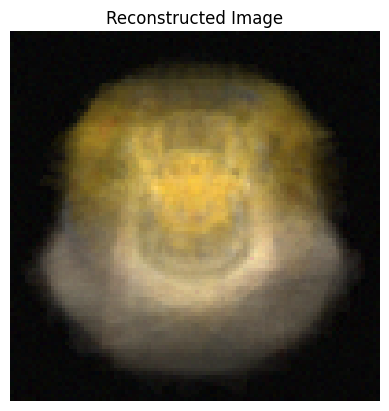

In [33]:
import matplotlib.pyplot as plt

# Reshape color_output to [height, width, channels] for visualization
# Assuming color_output corresponds to a single image in this example
image_height, image_width = 100, 100  # Adjust based on your actual image dimensions
num_channels = 3  # RGB

# Reshape and move data to CPU for visualization
image_reshaped = color_output.view(-1, image_height, image_width, num_channels).cpu().numpy()

# Select the first image if batch size > 1
image_to_show = image_reshaped[0]

# Normalize image for display
image_to_show = (image_to_show - image_to_show.min()) / (image_to_show.max() - image_to_show.min())

# Display the image
plt.imshow(image_to_show)
plt.title("Reconstructed Image")
plt.axis("off")  # Hide axis
plt.show()
